In [12]:
import torch.nn.functional as F
import torch
from torch import Tensor
from torchvision.transforms.functional import crop, resize

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [2]:
from cfa import sparse_ones, rgb_to_cfa, colorize_cfa

In [8]:
import os

def findAllFiles(path):
    res = []
    path, folders, files = next(os.walk(path))
    if folders:
        for f in folders:
            res.extend(findAllFiles(os.path.join(path, f)))
    res.extend([os.path.join(path, f) for f in files])
    return res

In [9]:
raw_folder = "../../raw-instinct/16bitRAW"
classes    = os.listdir(raw_folder)
raw_data   = [(c,[np.load(f).astype(np.int32)
                  for f in findAllFiles(os.path.join(raw_folder, c))]) 
              for c in classes]

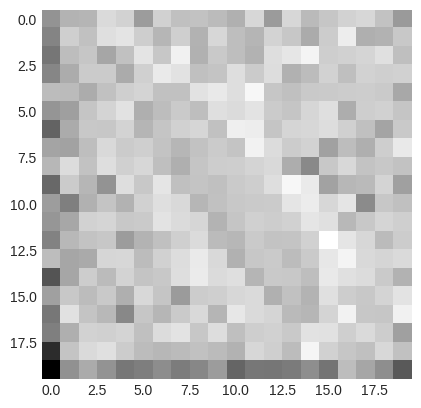

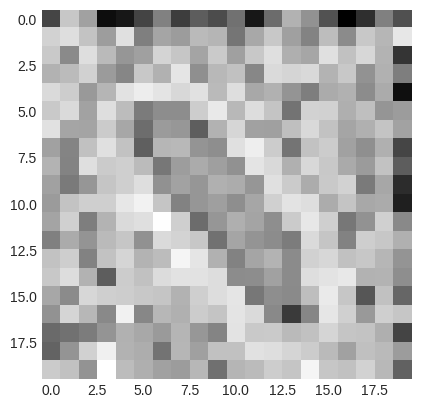

0.5234518647193909 0.4057725667953491


In [10]:
def chroma(mat):
    bayer_k = Tensor(sparse_ones((4,1,2,2), [(0,0,0,1),(1,0,0,0),(2,0,1,0),(3,0,1,1)]))
    rgb_k   = Tensor(sparse_ones((4,3,2,2), [(0,0,0,1),(1,1,0,0),(2,2,1,0),(3,1,1,1)]))
    cr_k    = Tensor(sparse_ones((2,3,2,2), [(1,1,1,0),(0,0,1,0)]))
    cb_k    = Tensor(sparse_ones((2,3,2,2), [(1,1,0,1),(0,2,0,1)]))
    g_int_k = Tensor(sparse_ones((3,3,3,3), [(1,1,0,1),(1,1,1,0),(1,1,1,2),(1,1,2,1)]) * 0.25)
    
    tensor = torch.Tensor(mat).unsqueeze(0)

    # CFA 1d -> RGB CFA 3d representation
    conv   = F.conv2d(          tensor, stride=2, weight=bayer_k, padding=1)
    rgb    = F.conv_transpose2d(conv,   stride=2, weight=rgb_k,   padding=1)

    # Interpolate green channel
    bi_g   = F.conv2d(          rgb,              weight=g_int_k, padding=1) + rgb

    # Extract green/red and green/blue
    cr_l   = F.conv2d(          bi_g,   stride=2, weight=cr_k)
    cb_l   = F.conv2d(          bi_g,   stride=2, weight=cb_k)

    # Calculate chrominance as two maps
    cr     = (cr_l[0] / cr_l[1])
    cb     = (cb_l[0] / cb_l[1])

    return cr, cb
    

def chromaMean(mat):
    cr, cb = chroma(mat)
    return torch.mean(cr).item(), torch.mean(cb).item()


test = raw_data[0][1][0]

cr, cb = chroma(test)

plt.style.use("seaborn-v0_8-dark")
plt.imshow((cr / cr.max()))
plt.show()
plt.imshow((cb / cb.max()))
plt.show()
print(torch.mean(cr).item(), torch.mean(cb).item())

In [14]:
raw_chroma = [(c, np.array([chromaMean(m) for m in lst])) for (c, lst) in raw_data]

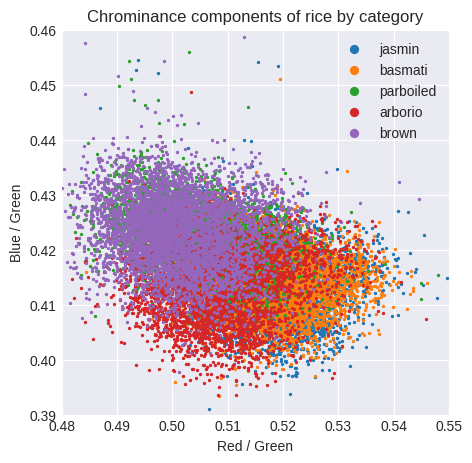

In [15]:
plt.style.use("seaborn-v0_8-darkgrid")
fig = plt.figure(figsize=(5,5))
ax  = plt.gca()
ax.set_title("Chrominance components of rice by category")
ax.set_ylim([0.39, 0.46])
ax.set_xlim([0.48,  0.55])
ax.set_xlabel("Red / Green")
ax.set_ylabel("Blue / Green")
for (c, lst) in raw_chroma:
    ax.scatter(*lst.T, s=2, label=c)

ax.legend(markerscale=4)

In [20]:
import math
flatten = lambda matrix: [item for row in matrix for item in row]

dataset     = raw_data
layout      = [(c, len(imgs)) for (c, imgs) in raw_data]
imgs        = flatten([imgs for (_, imgs) in dataset])
n_cells     = sum([l for (_, l) in layout])
cell_shape  = (40,40)
padding     = (0,0)
cell_w      = (padding[1]*2 + cell_shape[1])
dng_cells_w = math.ceil(math.sqrt(len(imgs)))
dng_px_w    = dng_cells_w * cell_w

res = np.zeros((dng_px_w, dng_px_w), dtype=np.uint16)

for n, img in enumerate(imgs):
    x = ((n % dng_cells_w)  * cell_w) + padding[0]
    y = ((n // dng_cells_w) * cell_w) + padding[1]
    res[x:x+cell_shape[0], y:y+cell_shape[1]] = img * (2**15 / img.max())

In [ ]:
from pidng.core import RAW2DNG, DNGTags, Tag
from pidng.defs import *

ccm1 = [[10000,10000], [10000,10000], [10000,10000],
        [10000,10000], [10000,10000], [10000,10000],
        [10000,10000], [10000,10000], [10000,10000]]
ccm1 = [[0,1], [0,1], [0,1],
        [0,1], [0,1], [0,1],
        [0,1], [0,1], [0,1]]

# Dual conversion
def saveRaw(cfa_img, bpp = 16, filename="custom"):
    height, width = cfa_img.shape
    
    # set DNG tags.
    t = DNGTags()
    t.set(Tag.ColorMatrix1, ccm1) # colour correction matrix

    t.set(Tag.ImageWidth, width)
    t.set(Tag.ImageLength, height)
    t.set(Tag.TileWidth, width)
    t.set(Tag.TileLength, height)
    t.set(Tag.Orientation, Orientation.Horizontal)
    t.set(Tag.PhotometricInterpretation, PhotometricInterpretation.Color_Filter_Array)
    t.set(Tag.SamplesPerPixel, 1)
    t.set(Tag.BitsPerSample, bpp)
    t.set(Tag.CFARepeatPatternDim, [2,2])
    t.set(Tag.CFAPattern, CFAPattern.GBRG)
    t.set(Tag.BlackLevel, (4096 >> (16 - bpp)))
    t.set(Tag.WhiteLevel, ((1 << bpp) -1) )
    t.set(Tag.CalibrationIlluminant1, CalibrationIlluminant.D65)
    t.set(Tag.Make, "No camera - Synthetically generated")
    t.set(Tag.Model, "v1")
    t.set(Tag.DNGVersion, DNGVersion.V1_4)
    t.set(Tag.DNGBackwardVersion, DNGVersion.V1_2)
    t.set(Tag.PreviewColorSpace, PreviewColorSpace.sRGB)
    
    # save to dng file.
    r = RAW2DNG()
    r.options(t, path="", compress=False)
    r.convert(cfa_img, filename=filename)

In [ ]:
saveRaw(res)

In [ ]:
img = torchvision.io.read_image("/home/gustav/Pictures/dumb-shit/teddy-chair.jpg").to(torch.float32)

In [ ]:
img_ds = F.avg_pool2d(img, 2)
img_bayer = rgb_to_bayer(img_ds).squeeze(0).permute(1,2,0)
plt.imshow(img_bayer / img_bayer.max())
img_bytes = np.array(img_bayer.sum(dim=2), dtype=np.uint16) * 2**8
img_bytes.max() / 2**16

In [ ]:
saveRaw(img_bytes, filename="teddy-chair")

In [ ]:
from PIL import Image

im = Image.open("/home/gustav/Pictures/dumb-shit/teddy-chair.jpg")
im.load()
print(im.info)

In [ ]:
img_roundtrip = torchvision.io.read_image("teddy-chair-demosaic-1.png").to(torch.float32)

img_diff = img_ds - img_roundtrip
img_diff_norm = (img_diff - img_diff.min()) / (img_diff.max() - img_diff.min())
plt.imshow(img_diff_norm.permute(1,2,0))
plt.show()

F.mse_loss(img_ds / 255, img_roundtrip / 255), img_diff_norm.max(), img_diff_norm.min(), img_diff.mean() / 255

In [ ]:
img_ct = torchvision.io.read_image("../color-test.jpg").to(torch.float32)
saveRaw(np.array(rgb_to_bayer(img_ct).sum(dim=1).squeeze(0) * 256, dtype=np.uint16), filename="ct")

In [ ]:
img_ct_roundtrip = torchvision.io.read_image("ct-1.png").to(torch.float32)

img_ct_diff = img_ct - img_ct_roundtrip
img_ct_diff_norm = (img_ct_diff - img_ct_diff.min()) / (img_ct_diff.max() - img_ct_diff.min())
plt.imshow(img_ct_diff.mean(dim=0).abs() / 256)
plt.colorbar()
plt.show()
img_ct_diff.max()

In [ ]:
img_ct[0][0][0], img_ct_roundtrip[0][0][0], img_ct_diff[0][0][0]